In [6]:
import requests , pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time 
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6

In [7]:
df=pd.read_csv(r'F:\DATA Competition L and T\train_Data.csv')
df

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0
...,...,...,...,...,...,...
80397,2019-07-19,2,NaN,WEST BENGAL,NaN,1886.0
80398,2019-07-20,2,NaN,WEST BENGAL,NaN,1480.0
80399,2019-07-21,2,NaN,WEST BENGAL,NaN,1028.0
80400,2019-07-22,2,NaN,WEST BENGAL,NaN,1946.0


In [8]:
print(df.dtypes)

application_date     object
segment               int64
branch_id           float64
state                object
zone                 object
case_count          float64
dtype: object


In [9]:
df['application_date']=pd.to_datetime(df['application_date'])
index_df=df.set_index('application_date')
ts=index_df['case_count']
ts.head(5)

application_date
2017-04-01     40.0
2017-04-03      5.0
2017-04-04      4.0
2017-04-05    113.0
2017-04-07     76.0
Name: case_count, dtype: float64

In [10]:
print(df.dtypes)

application_date    datetime64[ns]
segment                      int64
branch_id                  float64
state                       object
zone                        object
case_count                 float64
dtype: object


C:\Users\ssc\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


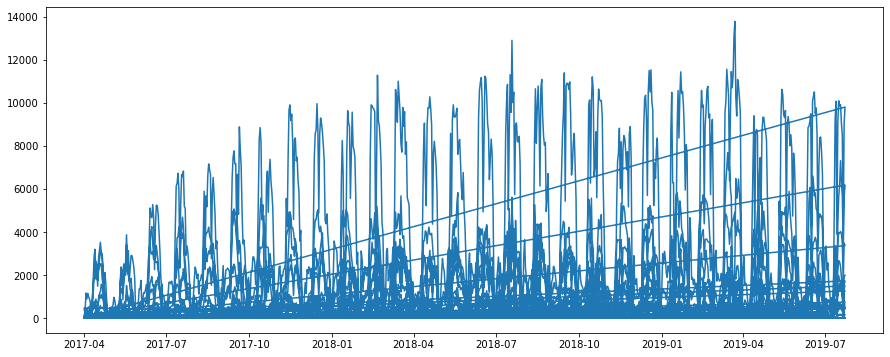

In [11]:
plt.plot(ts)

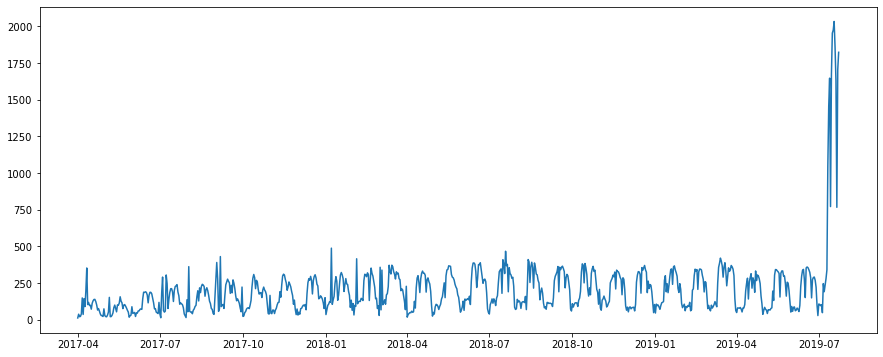

In [17]:
ts_daily=ts.resample('D').mean()
plt.plot(ts_daily)

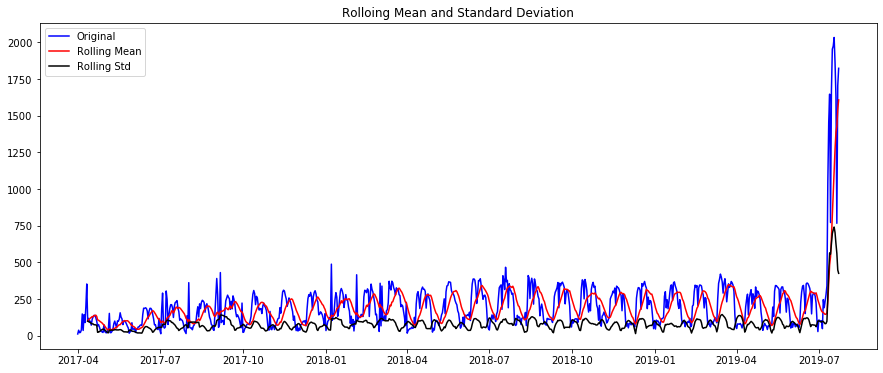

result of Dickey-Fuller test:
Test statastics                 0.429184
p-value                         0.982554
#lags used                     20.000000
Number of observation used    823.000000
Critical Value (1%)            -3.438321
Critical Value (5%)            -2.865058
Critical Value (10%)           -2.568643
dtype: float64


In [18]:
def test_stationarity(timeseries):
#determining the rolling statstics
    rolmean=timeseries.rolling(window=12,center=False).mean()
    rolstd=timeseries.rolling(window=12,center=False).std()
    #plot rolling statstics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolloing Mean and Standard Deviation')
    plt.show(block=False)
    # perform Dickey-fuller test"
    print('result of Dickey-Fuller test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test statastics','p-value','#lags used','Number of observation used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)
test_stationarity(ts_daily)

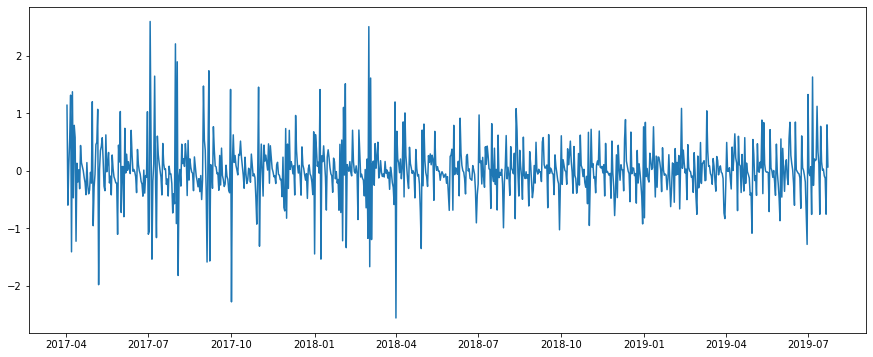

In [19]:
ts_daily_log=np.log(ts_daily)
ts_daily_log_diff=ts_daily_log-ts_daily_log.shift()
plt.plot(ts_daily_log_diff)

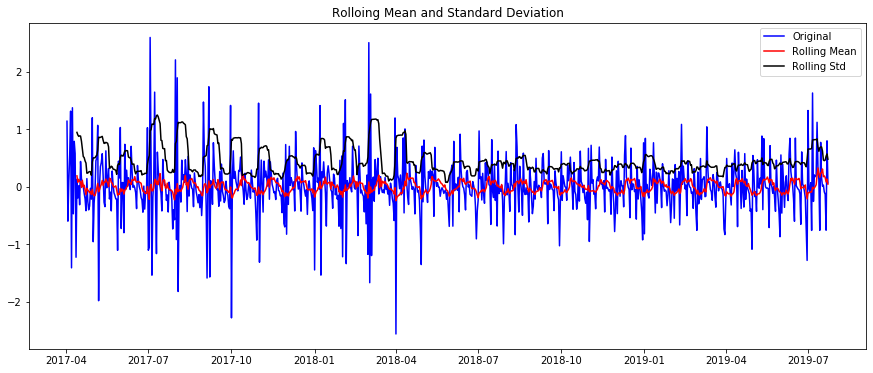

result of Dickey-Fuller test:
Test statastics              -1.397389e+01
p-value                       4.296224e-26
#lags used                    2.000000e+01
Number of observation used    8.220000e+02
Critical Value (1%)          -3.438330e+00
Critical Value (5%)          -2.865063e+00
Critical Value (10%)         -2.568646e+00
dtype: float64


In [25]:
ts_daily_log_diff.dropna(inplace=True)
test_stationarity(ts_daily_log_diff)

In [26]:
# ACF and PACF
lag_acf=acf(ts_daily_log_diff,nlags=10)
lag_pacf=pacf(ts_daily_log_diff,nlags=10,method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

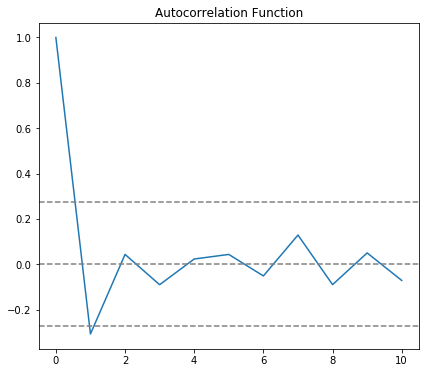

In [28]:
# Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_daily_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_daily_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

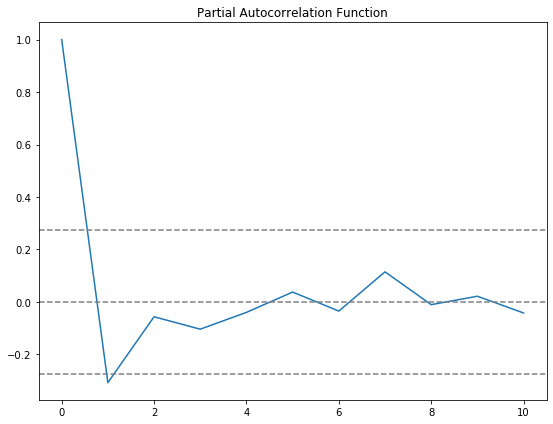

In [30]:
# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_daily_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_daily_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 179.3160')

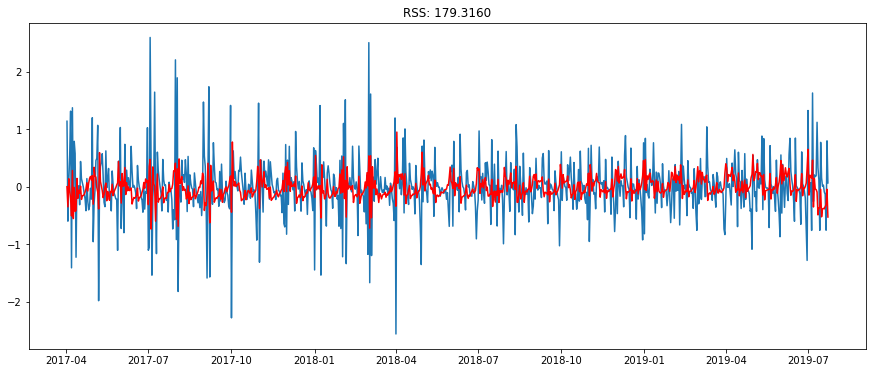

In [89]:
model=ARIMA(ts_daily_log,order=(2,1,2))
results_ARIMA=model.fit(disp=-1)
plt.plot(ts_daily_log_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues-ts_daily_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:           D.case_count   No. Observations:                  843
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -542.510
Method:                       css-mle   S.D. of innovations              0.459
Date:                Tue, 21 Jan 2020   AIC                           1097.020
Time:                        16:01:43   BIC                           1125.442
Sample:                    04-02-2017   HQIC                          1107.912
                         - 07-23-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0013      0.000      3.785      0.000       0.001       0.002
ar.L1.D.case_count     0.4983      0.182      2.736      0.006       0.141       0.855
ar.L2.D.case_count  

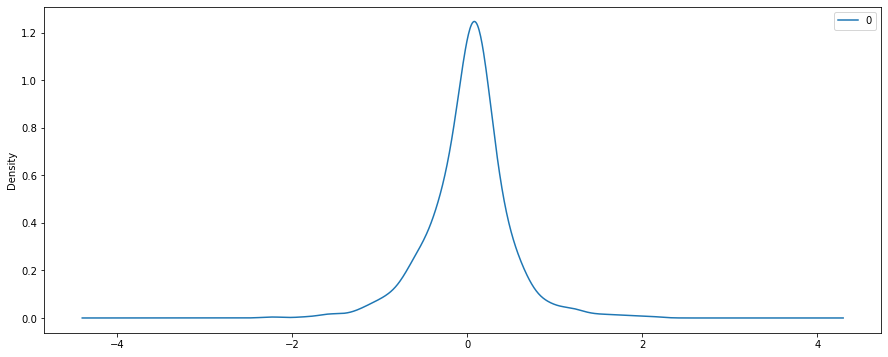

In [90]:
print(results_ARIMA.summary())
# Plot residual errors
residuals=DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde') #kde=commulative density function
print(residuals.describe())

In [91]:
Prediction_ARIMA_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
print(Prediction_ARIMA_diff.head())

application_date
2017-04-02    0.001302
2017-04-03   -0.348724
2017-04-04    0.139812
2017-04-05   -0.067862
2017-04-06   -0.205303
Freq: D, dtype: float64


C:\Users\ssc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


Text(0.5, 1.0, 'RMSE:291.7588')

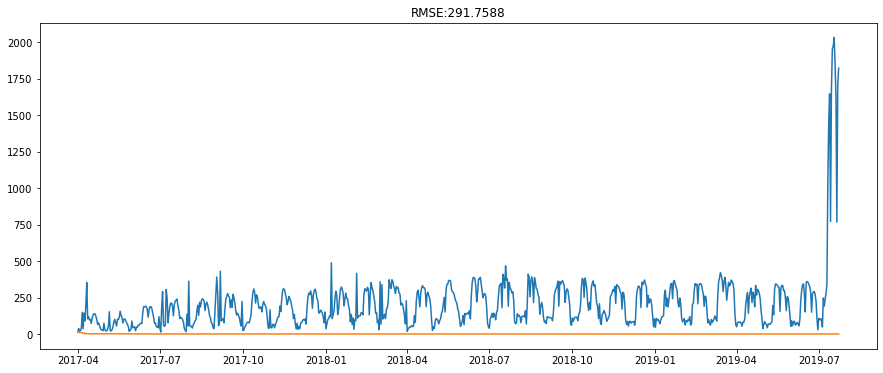

In [92]:
Prediction_ARIMA_Diff_Cumsum=Prediction_ARIMA_diff.cumsum()
Predictions_ARIMA_log=pd.Series(ts_daily_log.ix[0],index=ts_daily_log.index)
Predictions_ARIMA_log=Predictions_ARIMA_log.add(Prediction_ARIMA_Diff_Cumsum,fill_value=0)
Predictions_ARIMA=np.exp(Predictions_ARIMA_log)
plt.plot(ts_daily)
plt.plot(Predictions_ARIMA)
plt.title('RMSE:%.4f'%np.sqrt(sum((Predictions_ARIMA-ts_daily)**2)/len(ts_daily)))

In [107]:
size=int(len(ts_daily_log)-15)
train,test=ts_daily_log[0:size],ts_daily_log[size:len(ts_daily_log)]
history=[x for x in train]
predictions=list()
print('printing Predictions and Expected Values...')
print('\n')
for t in range (len(test)):
    model=ARIMA(history,order=(3,1,1))
    model_fit=model.fit(disp=0)
    output=model_fit.forecast()
    yhat=output[0]
    predictions.append(float(yhat))
    obs=test[t]
    history.append(obs)
    print('predicted=%f, expected=%f'%(np.exp(yhat),np.exp(obs)))

printing Predictions and Expected Values...




C:\Users\ssc\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ssc\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ssc\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\ssc\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted=216.886506, expected=280.187500
predicted=254.104073, expected=340.312500
predicted=295.627360, expected=1046.000000
predicted=688.907383, expected=1455.250000
predicted=1152.885675, expected=1647.500000
predicted=1358.490447, expected=771.937500
predicted=923.543697, expected=1673.062500
predicted=1356.576289, expected=1954.812500
predicted=1888.666109, expected=1975.250000
predicted=1823.220173, expected=2034.187500
predicted=1966.551590, expected=1861.125000
predicted=1914.117471, expected=1632.687500
predicted=1725.968547, expected=766.687500
predicted=1014.760509, expected=1705.750000
predicted=1434.256383, expected=1823.937500


In [108]:
# validate the model
error=mean_squared_error(test,predictions)
print('\n')
print('Printing mean square error of predictions...')
print('Test MSE:%0.6f'%error)
predictions_series=pd.Series(predictions,index=test.index)



Printing mean square error of predictions...
Test MSE:0.284578
